In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import struct
from scipy import interpolate

%matplotlib inline

(0, 1)

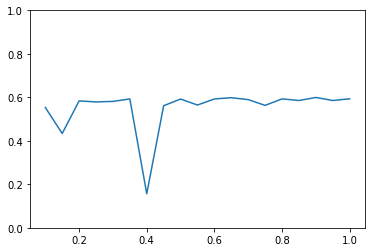

In [43]:
result_dir = '../results/cifar10/hns/deterministic/full_training/'
result_file = result_dir + 'results.pkl'
alphas = [x[0] for x in sorted(results.items(), key=lambda kv: kv[0])]
accuracies_none = [x[1] for x in sorted(results.items(), key=lambda kv: kv[0])]
results = pkl.load(open(result_file, 'rb'))
plt.plot(alphas, accuracies_none)
plt.ylim([0, 1])

(0, 1)

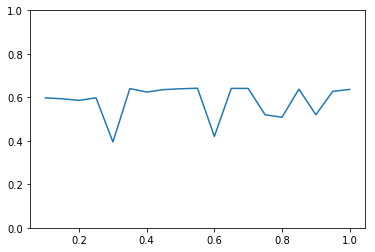

In [38]:
result_dir = '../results/cifar10/hns/deterministic/pretrained_both/'
result_file = result_dir + 'results.pkl'
alphas = [x[0] for x in sorted(results.items(), key=lambda kv: kv[0])]
accuracies_both = [x[1] for x in sorted(results.items(), key=lambda kv: kv[0])]
results = pkl.load(open(result_file, 'rb'))
plt.plot(alphas, accuracies_both)
plt.ylim([0, 1])

(0, 1)

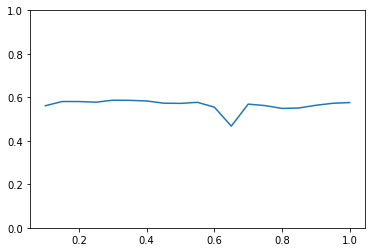

In [39]:
result_dir = '../results/cifar10/hns/deterministic/pretrained_hider/'
result_file = result_dir + 'results.pkl'
alphas = [x[0] for x in sorted(results.items(), key=lambda kv: kv[0])]
accuracies_hider = [x[1] for x in sorted(results.items(), key=lambda kv: kv[0])]
results = pkl.load(open(result_file, 'rb'))
plt.plot(alphas, accuracies_hider)
plt.ylim([0, 1])

(0, 1)

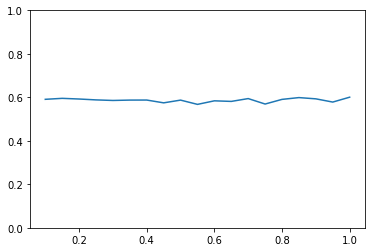

In [40]:
result_dir = '../results/cifar10/hns/deterministic/pretrained_seeker/'
result_file = result_dir + 'results.pkl'
alphas = [x[0] for x in sorted(results.items(), key=lambda kv: kv[0])]
accuracies_seeker = [x[1] for x in sorted(results.items(), key=lambda kv: kv[0])]
results = pkl.load(open(result_file, 'rb'))
plt.plot(alphas, accuracies_seeker)
plt.ylim([0, 1])

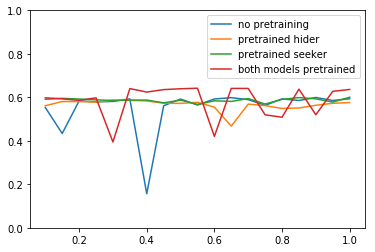

In [44]:
plt.plot(alphas, accuracies_none, label='no pretraining')
plt.plot(alphas, accuracies_hider, label='pretrained hider')
plt.plot(alphas, accuracies_seeker, label='pretrained seeker')
plt.plot(alphas, accuracies_both, label='both models pretrained')
plt.ylim([0, 1])
plt.legend()

## tensorboard

In [2]:
def read_hns_batch_logs(path_to_events_file):
    logs = {'classification loss': [],
            'gradients': [],
            'loss monitor': [],
            'loss regulator': [],
            'mask loss': [],
            'percentage hidden': [],
            'pixels hidden': [],
            'pixels kept': [],
            'total loss': []}

    for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
        for v in e.summary.value:
            logs[v.tag].append(struct.unpack('f', v.tensor.tensor_content)[0])
            
    return pd.DataFrame(logs)

In [61]:
def load_and_process_logs(batch_event_files, resample_one_every=10, extend_to_length=39100):
    
    def resample_log(log, one_every=10):
        interp_values = np.linspace(log.step.iloc[0], log.step.iloc[-1], len(log)//one_every)
        new_columns = {}
        for c in log.columns:
            if c == 'step':
                new_columns[c] = range(len(interp_values))
            else:
                f = interpolate.interp1d(log['step'], log[c])
                new_columns[c] = f(interp_values)

        return pd.DataFrame(new_columns)

    # Read log files
    logs = []
    for ev in batch_event_files:
        log = read_hns_batch_logs(ev) 
        log['step'] = log.index
        logs.append(log)

    # make extend the logs that have stopped earlier
    if extend_to_length:
        max_len = extend_to_length
    else:
        max_len = max([len(log) for log in logs])

    new_logs = []
    
    for log in logs:
        steps = range(log.iloc[-1, -1] + 1, max_len)
        length = max_len - log.iloc[-1, -1] - 1
        pad = {c: [None] * length for c in log.columns}
        pad['step'] = steps
        pad = pd.DataFrame(pad)
        fill_vals = log[-10:].mean()
        log = pd.concat([log, pad], sort=False)
        log = log.fillna(fill_vals)
        if resample_one_every:
            log = resample_log(log, one_every=resample_one_every)
        new_logs.append(log)

    #logs_df = pd.concat(new_logs)
    return new_logs

In [62]:
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
experiments = Path('../logs/cifar10/hns/deterministic/full_training_10/').glob('*')
batch_event_files = [str(list((d / 'batch').glob('*'))[0]) for d in experiments]
logs = load_and_process_logs(batch_event_files, resample_one_every=10)

In [177]:
def fancy_plot(logs, column_name, best_plot, color='C0'):
    max_trace = [max([log[column_name].iloc[i] for log in logs]) for i in range(len(logs[0]))]
    min_trace = [min([log[column_name].iloc[i] for log in logs]) for i in range(len(logs[0]))]
    plt.plot(logs[best_plot]['step'], logs[best_plot][column_name], color=color)
    plt.plot(logs[best_plot]['step'], max_trace, color=color, alpha=0.6, zorder=-1)
    plt.plot(logs[best_plot]['step'], min_trace, color=color, alpha=0.6, zorder=-1)

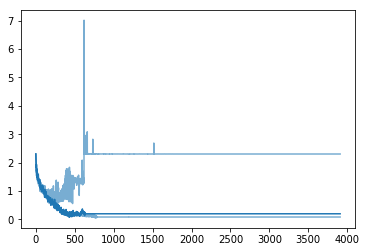

In [178]:
fancy_plot(logs, 'classification loss', 0)

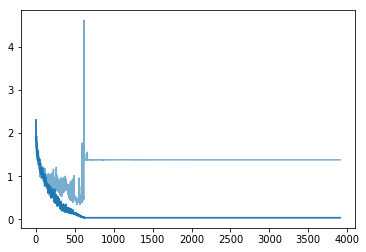

In [65]:
fancy_plot(logs, 'total loss', 0)

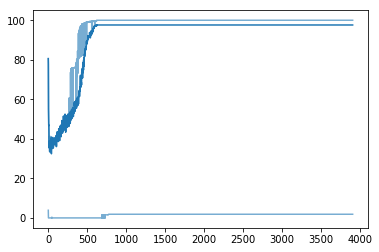

In [66]:
fancy_plot(logs, 'percentage hidden', 0)

In [67]:
def load_and_process_logs_from_dir(log_dir, resample_one_every=10):
    batch_event_files = [str(list((d / 'batch').glob('*'))[0]) for d in Path(log_dir).glob('*')]
    return load_and_process_logs(batch_event_files, resample_one_every=resample_one_every)

In [68]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_hider_10/'
hider_logs = load_and_process_logs_from_dir(experiment_dir, resample_one_every=10)

In [179]:
def full_plot(logs, column_name):
    for i in range(len(logs)):
        plt.plot(logs[i]['step'], logs[i][column_name], label=str(i))
    plt.legend()

(0, 0.3)

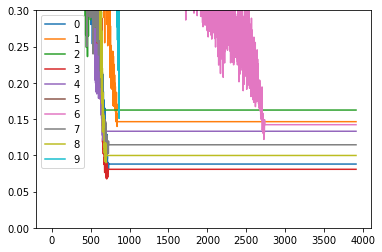

In [180]:
full_plot(hider_logs, 'total loss')
plt.ylim(0, 0.3)

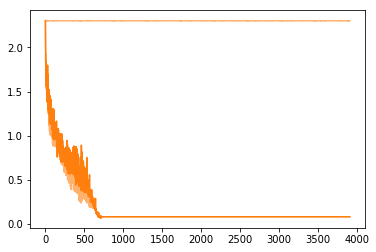

In [88]:
fancy_plot(hider_logs, 'total loss', 3, color='C1')

(0, 2.5)

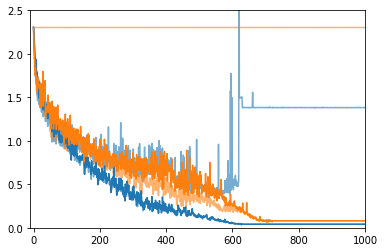

In [89]:
fancy_plot(logs, 'total loss', 0)
fancy_plot(hider_logs, 'total loss', 3, color='C1')
plt.xlim([-10, 1000])
plt.ylim([0, 2.5])

(-10, 1000)

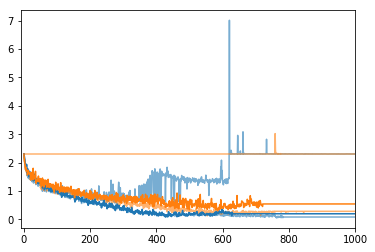

In [92]:
fancy_plot(logs, 'classification loss', 0)
fancy_plot(hider_logs, 'classification loss', 3, color='C1')
plt.xlim([-10, 1000])
#plt.ylim([0, 2.5])

(-10, 1000)

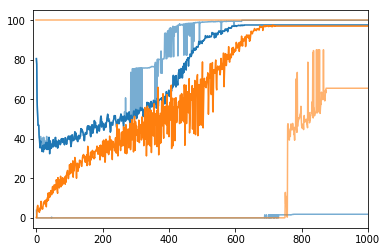

In [93]:
fancy_plot(logs, 'percentage hidden', 0)
fancy_plot(hider_logs, 'percentage hidden', 3, color='C1')
plt.xlim([-10, 1000])
#plt.ylim([0, 2.5])

In [94]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_both_10/'
both_logs = load_and_process_logs_from_dir(experiment_dir, resample_one_every=20)

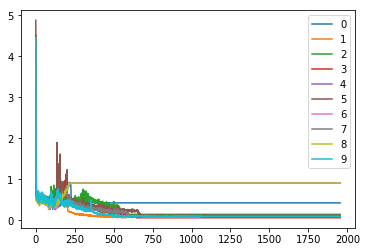

In [97]:
full_plot(both_logs, 'total loss')
plt.ylim([0, 0.3])

(0, 2.5)

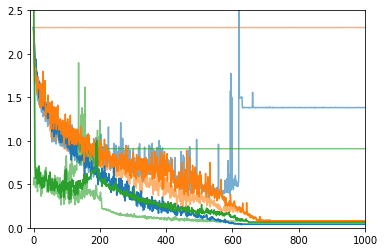

In [99]:
fancy_plot(logs, 'total loss', 0)
fancy_plot(hider_logs, 'total loss', 3, color='C1')
fancy_plot(both_logs, 'total loss', 3, color='C2')
plt.xlim([-10, 1000])
plt.ylim([0, 2.5])

(0, 2.5)

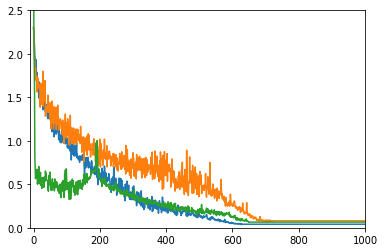

In [101]:
plt.plot(logs[0]['total loss'])
plt.plot(hider_logs[3]['total loss'])
plt.plot(both_logs[3]['total loss'])
plt.xlim([-10, 1000])
plt.ylim([0, 2.5])

In [187]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_seeker_10/'
seeker_logs = load_and_process_logs_from_dir(experiment_dir, resample_one_every=20)

(0, 0.3)

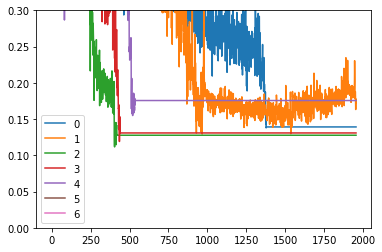

In [188]:
full_plot(seeker_logs, 'total loss')
plt.ylim([0, 0.3])

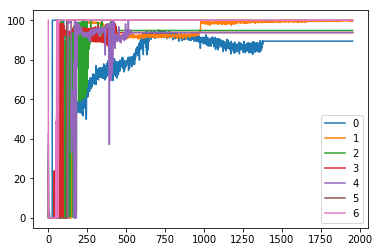

In [189]:
full_plot(seeker_logs, 'percentage hidden')

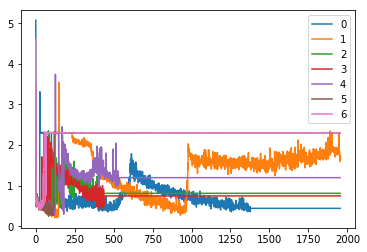

In [190]:
full_plot(seeker_logs, 'classification loss')

In [106]:
epoch_event_files = [str(list((d / 'epoch').glob('*'))[0]) for d in Path('../logs/cifar10/hns/deterministic/pretrained_seeker_10/').glob('*')]

In [143]:
def load_and_process_epoch_logs_from_dir(log_dir, extend_to_length=200):

    def read_hns_epoch_logs(path_to_events_file):
        logs = {'Average loss per epoch': [],
                'Validation accuracy': []}
        
        for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
            for v in e.summary.value:
                logs[v.tag].append(struct.unpack('f', v.tensor.tensor_content)[0])
                
        if len(logs['Validation accuracy']) < len(logs['Average loss per epoch']):
            logs['Validation accuracy'].append(logs['Validation accuracy'][-1])
        
        return pd.DataFrame(logs)
    
    epoch_event_files = [str(list((d / 'epoch').glob('*'))[0]) for d in Path(log_dir).glob('*')]

    # Read log files
    logs = []
    for ev in epoch_event_files:
        log = read_hns_epoch_logs(ev) 
        log['step'] = log.index
        logs.append(log)

    # make extend the logs that have stopped earlier
    if extend_to_length:
        max_len = extend_to_length
    else:
        max_len = max([len(log) for log in logs])

    new_logs = []
    
    for log in logs:
        steps = range(log.iloc[-1, -1] + 1, max_len)
        length = max_len - log.iloc[-1, -1] - 1
        pad = {c: [None] * length for c in log.columns}
        pad['step'] = steps
        pad = pd.DataFrame(pad)
        fill_vals = log.iloc[-1]
        log = pd.concat([log, pad], sort=False)
        log = log.fillna(fill_vals)
        new_logs.append(log)

    return new_logs

In [145]:
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
full_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)

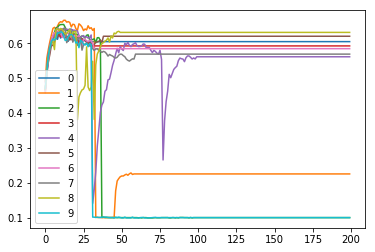

In [182]:
full_plot(full_epoch_logs, 'Validation accuracy')

(0.4, 0.7)

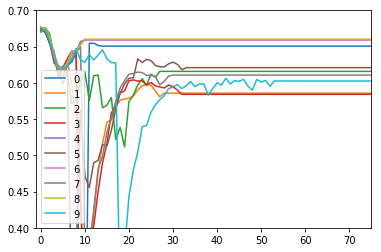

In [206]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_both_10/'
both_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
full_plot(both_epoch_logs, 'Validation accuracy')
plt.xlim(-1, 75)
plt.ylim(0.4, 0.7)

In [172]:
l2 = l2.fillna(fill_vals)

In [174]:
full_epoch_logs[0]

,Average loss per epoch,Validation accuracy,step
0,1.800938,0.467480,0
1,1.423840,0.524414,1
2,1.266091,0.554102,2
3,1.144916,0.586719,3
4,1.037605,0.611230,4
5,0.946319,0.616992,5
6,0.855842,0.626270,6
7,0.772705,0.630957,7
8,0.721202,0.611328,8
9,0.660277,0.631250,9


(-1, 75)

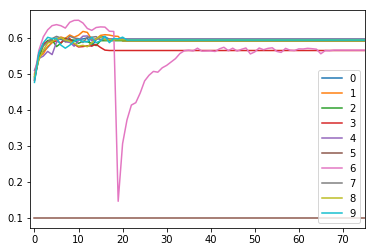

In [211]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_hider_10/'
hider_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
full_plot(hider_epoch_logs, 'Validation accuracy')
plt.xlim(-1, 75)
#plt.ylim(0.4, 0.7)

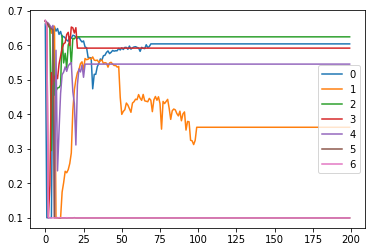

In [186]:
experiment_dir = '../logs/cifar10/hns/deterministic/pretrained_seeker_10/'
seeker_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
full_plot(seeker_epoch_logs, 'Validation accuracy')

(-1, 50)

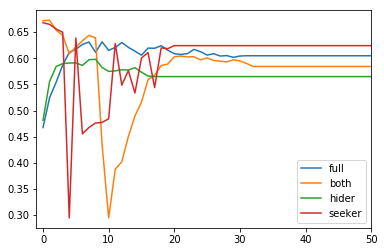

In [198]:
plt.plot(full_epoch_logs[0]['step'], full_epoch_logs[0]['Validation accuracy'], label='full')
plt.plot(both_epoch_logs[3]['step'], both_epoch_logs[3]['Validation accuracy'], label='both')
plt.plot(hider_epoch_logs[3]['step'], hider_epoch_logs[3]['Validation accuracy'], label='hider')
plt.plot(seeker_epoch_logs[2]['step'], seeker_epoch_logs[2]['Validation accuracy'], label='seeker')

plt.legend()
plt.xlim([-1, 50])
#plt.ylim([0, 2.5])

(-10, 1000)

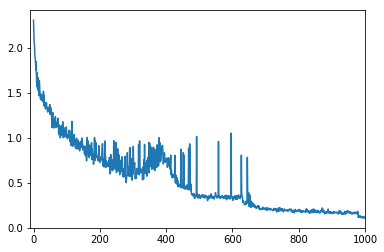

In [196]:
plt.plot(logs[8]['total loss'])
#plt.plot(hider_logs[3]['total loss'])
#plt.plot(both_logs[3]['total loss'])
plt.xlim([-10, 1000])
#plt.ylim([0, 2.5])

(-10, 1000)

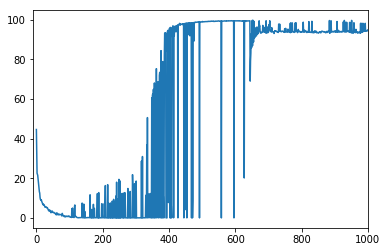

In [199]:
plt.plot(logs[8]['percentage hidden'])
plt.xlim([-10, 1000])

(-10, 1000)

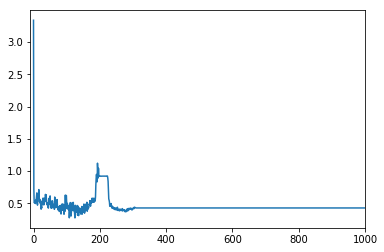

In [202]:
plt.plot(both_logs[0]['total loss'])
plt.xlim([-10, 1000])

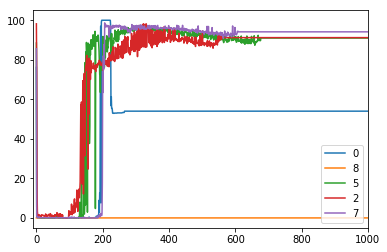

In [208]:
plt.plot(both_logs[0]['percentage hidden'], label='0')
plt.plot(both_logs[8]['percentage hidden'], label='8')
plt.plot(both_logs[5]['percentage hidden'], label='5')
plt.plot(both_logs[2]['percentage hidden'], label='2')
plt.plot(both_logs[7]['percentage hidden'], label='7')
plt.xlim([-10, 1000])

plt.legend(loc='lower right')

(-10, 1000)

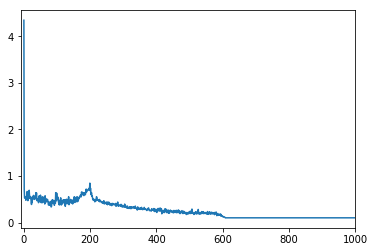

In [209]:
plt.plot(both_logs[7]['total loss'])
plt.xlim([-10, 1000])

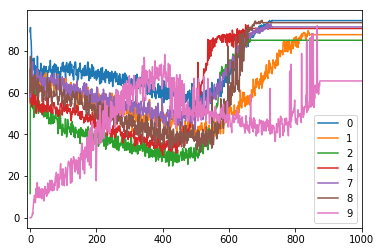

In [215]:
plt.plot(hider_logs[0]['percentage hidden'], label='0')
plt.plot(hider_logs[1]['percentage hidden'], label='1')
plt.plot(hider_logs[2]['percentage hidden'], label='2')
plt.plot(hider_logs[4]['percentage hidden'], label='4')
plt.plot(hider_logs[7]['percentage hidden'], label='7')
plt.plot(hider_logs[8]['percentage hidden'], label='8')
plt.plot(hider_logs[9]['percentage hidden'], label='9')
plt.xlim([-10, 1000])
plt.legend(loc='lower right')

(-10, 1000)

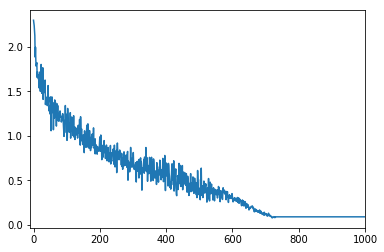

In [217]:
plt.plot(hider_logs[0]['total loss'])
plt.xlim([-10, 1000])

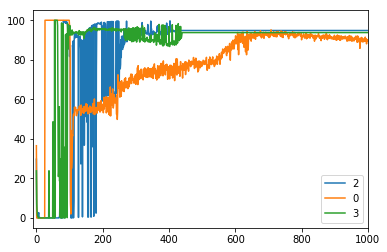

In [218]:
plt.plot(seeker_logs[2]['percentage hidden'], label='2')
plt.plot(seeker_logs[0]['percentage hidden'], label='0')
plt.plot(seeker_logs[3]['percentage hidden'], label='3')
plt.xlim([-10, 1000])
plt.legend(loc='lower right')

(-10, 1000)

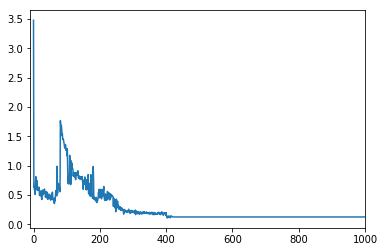

In [219]:
plt.plot(seeker_logs[2]['total loss'])
plt.xlim([-10, 1000])

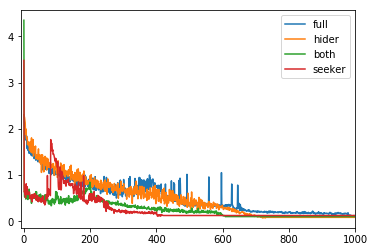

In [221]:
plt.plot(logs[8]['total loss'], label='full')
plt.plot(hider_logs[0]['total loss'], label='hider')
plt.plot(both_logs[7]['total loss'], label='both')
plt.plot(seeker_logs[2]['total loss'], label='seeker')
plt.xlim([-10, 1000])
#plt.ylim([0, 2.5])
plt.legend()

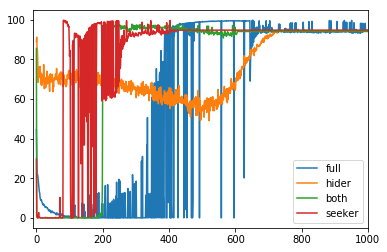

In [222]:
plt.plot(logs[8]['percentage hidden'], label='full')
plt.plot(hider_logs[0]['percentage hidden'], label='hider')
plt.plot(both_logs[7]['percentage hidden'], label='both')
plt.plot(seeker_logs[2]['percentage hidden'], label='seeker')
plt.xlim([-10, 1000])
plt.legend(loc='lower right')

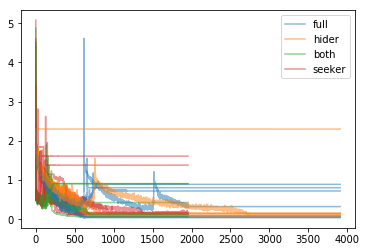

In [227]:
plt.plot(logs[0]['total loss'], label='full', c='C0', alpha=0.5)
plt.plot(hider_logs[0]['total loss'], label='hider', c='C1', alpha=0.5)
plt.plot(both_logs[0]['total loss'], label='both', c='C2', alpha=0.5)
plt.plot(seeker_logs[0]['total loss'], label='seeker', c='C3', alpha=0.5)
plt.legend()

for i in range(1, 7):
    plt.plot(logs[i]['total loss'], c='C0', alpha=0.5)
    plt.plot(hider_logs[i]['total loss'], c='C1', alpha=0.5)
    plt.plot(both_logs[i]['total loss'], c='C2', alpha=0.5)
    plt.plot(seeker_logs[i]['total loss'], c='C3', alpha=0.5)

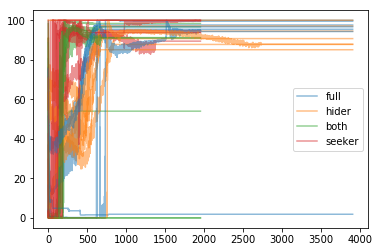

In [228]:
plt.plot(logs[0]['percentage hidden'], label='full', c='C0', alpha=0.5)
plt.plot(hider_logs[0]['percentage hidden'], label='hider', c='C1', alpha=0.5)
plt.plot(both_logs[0]['percentage hidden'], label='both', c='C2', alpha=0.5)
plt.plot(seeker_logs[0]['percentage hidden'], label='seeker', c='C3', alpha=0.5)
plt.legend()

for i in range(1, 7):
    plt.plot(logs[i]['percentage hidden'], c='C0', alpha=0.5)
    plt.plot(hider_logs[i]['percentage hidden'], c='C1', alpha=0.5)
    plt.plot(both_logs[i]['percentage hidden'], c='C2', alpha=0.5)
    plt.plot(seeker_logs[i]['percentage hidden'], c='C3', alpha=0.5)